In [ ]:
 pip install datasets transformers huggingface_hub

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from huggingface_hub import notebook_login
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score
import seaborn as sn
from matplotlib import pyplot as plt

In [ ]:
notebook_login()

In [ ]:
dataset = load_dataset("HFFErica/topicclassificaition", data_files={'train': 'train_filter.csv', 'test': 'test_filter.csv'})
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train_filter.csv:   0%|          | 0.00/354k [00:00<?, ?B/s]

test_filter.csv:   0%|          | 0.00/149k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Order', 'text', 'final_topic', 'topics', 'label'],
        num_rows: 2169
    })
    test: Dataset({
        features: ['Order', 'text', 'final_topic', 'topics', 'label'],
        num_rows: 919
    })
})

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
# Preprocess dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/919 [00:00<?, ? examples/s]

In [ ]:
# Load model
num_labels = len(set(train_dataset['label']))
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=num_labels)

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Check if logits are in a tuple, and extract if needed
    if isinstance(logits, tuple):
        logits = logits[0]

    # Convert logits to a NumPy array if it's a PyTorch tensor
    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()

    # Apply argmax to get predicted classes (axis=1 is used for NumPy arrays)
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./zetoresults",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Use smaller batches
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps (simulates batch_size = 4*4=16)
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

<ipython-input-10-c66f326b03d8>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,4.074191,0.091404,0.091404,0.091404,0.091404
1,No log,2.901457,0.376496,0.376496,0.376496,0.376496
2,No log,2.545713,0.447225,0.447225,0.447225,0.447225


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


{'eval_loss': 2.54571270942688, 'eval_accuracy': 0.4472252448313384, 'eval_precision': 0.4472252448313384, 'eval_recall': 0.4472252448313384, 'eval_f1': 0.4472252448313384, 'eval_runtime': 115.2258, 'eval_samples_per_second': 7.976, 'eval_steps_per_second': 0.998, 'epoch': 2.990791896869245}


In [ ]:
# Save the model and tokenizer to a directory
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [ ]:
# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8', '9': 'LABEL_9', '10': 'LABEL_10', '11': 'LABEL_11', '12': 'LABEL_12', '13': 'LABEL_13', '14': 'LABEL_14', '15': 'LABEL_15', '16': 'LABEL_16', '17': 'LABEL_17', '18': 'LABEL_18', '19': 'LABEL_19', '20': 'LABEL_20', '21': 'LABEL_21', '22': 'LABEL_22', '23': 'LABEL_23', '24': 'LABEL_24', '25': 'LABEL_25', '26': 'LABEL_26', '27': 'LABEL_27', '28': 'LABEL_28', '29': 'LABEL_29', '30': 'LABEL_30', '31': 'LABEL_31', '32': 'LABEL_32', '33': 'LABEL_33', '34': 'LABEL_34', '35': 'LABEL_35', '36': 'LABEL_36', '37': 'LABEL_37', '38': 'LABEL_38', '39': 'LABEL_39', '40': 'LABEL_40', '41': 'LABEL_41', '42': 'LABEL_42', '43': 'LABEL_43', '44': 'LABEL_44', '45': 'LABEL_45', '46': 'LABEL_46', '47': 'LABEL_47', '48': 'LABEL_48', '49': 'LABEL_49', '50': 'LABEL_50', '51': 'LABEL_51', '52': 'LABEL_

In [ ]:
label_mapping = {
1: "Accessibility options",
2: "Audio",
3: "BugsCrashing",
4: "Camera control",
6: "Combat mechanics",
7: "Comparison",
9: "Content filter",
10: "Controls",
11: "Creative mechanics",
12: "Customisation",
13: "Developer",
14: "Development states",
15: "DifficultyBalance",
16: "Emotion",
17: "Engaging",
19: "Exploration",
20: "Game awareness duration",
21: "GameEvaluation",
22: "GameProgression",
23: "Graphics settings",
24: "Guide and Tutorials",
25: "ImmersionRealism",
26: "In-game economic mechanics",
27: "In-game physics mechanics",
28: "InteractionSocialisation",
29: "Language settings and Localisation",
31: "Learnability",
32: "Management mechanics",
33: "Mode settings",
34: "Movement mechanics",
35: "Narrative",
36: "Navigation and Maps",
37: "Novelty",
38: "OnlineVideo",
39: "Order state",
41: "PersonalInfluence",
42: "Platforms",
43: "Players modification and Workshops",
44: "Playtime and Gameplay length",
45: "PriceQuality ratio",
46: "Promotion strategy and Marketing collateral",
47: "Puzzle mechanics",
48: "Recommendation",
49: "Refund",
50: "Returning player",
52: "Review reception",
54: "Server",
56: "Social identity",
57: "Survival mechanics",
58: "UIandUX",
59: "Update",
60: "Virtual reality headset",
61: "VisualAtmosphere"
}

In [ ]:
import torch

# Example texts to classify
texts = [
    "They need the audio to be more random more audio files to randomly choose from so you get a more unique experience on every play through.",
    "unfortunately, some bugs like characters getting stuck permanently in a spot have also made a comeback lmao.",
    "I've had the game for a long time, and it was pretty fun for the first 30-50 hours",
    "Very cool story, which I had not expected. Exploration, ship fights, and base building is incredibly fun. Looking forward to Worlds Part 2 update.",
    "There is just so much to do in this big, beautiful game that you can just follow your whim and do what you want. ",
    "the planets are sometimes so good looking I hardly believe its procedural! "
]

# Tokenize the input text
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Make predictions (logits) using the model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class (with argmax to select the highest scoring class)
predictions = torch.argmax(outputs.logits, dim=-1)

# Map predicted class indices to actual label names (assuming you know the label mapping)
predicted_labels_mapping = [label_mapping[pred.item()] for pred in predictions]
predicted_labels = [pred.item() for pred in predictions]

print(predicted_labels)
print(predicted_labels_mapping)

[2, 3, 44, 35, 19, 61]
['Audio', 'BugsCrashing', 'Playtime and Gameplay length', 'Narrative', 'Exploration', 'VisualAtmosphere']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/visual results/RepeatExperimentData/test_filter.csv')
data['text']

,text
0,it is honestly weird to me that a game from a ...
1,but no option/support/inclusion of subtitles a...
2,"Like most games, this one doesn't have left ha..."
3,"in 21st centry, there's yet another game can't..."
4,how on earth can a game released in 2018 and s...
...,...
914,the game is so outstanding and amazing with co...
915,"The diverse and vibrant environments,"
916,"With the addition of photo mode stuff,"
917,if you do not already know it is a hospital si...


In [ ]:
def predict_topic(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    # Make prediction using the model (with torch.no_grad to avoid computing gradients)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (with argmax to select the highest scoring class)
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()

    # Map the predicted class index to the label name
    predicted_label = label_mapping[predicted_class]

    return predicted_label

In [ ]:
from tqdm import tqdm

tqdm.pandas()
data['predicted_label'] = data['text'].apply(predict_topic)
data.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/zero_predicted_labels_output.csv', index=False)

In [ ]:
print(data.head())

   Order                                               text  \
0    257  it is honestly weird to me that a game from a ...   
1    657  but no option/support/inclusion of subtitles a...   
2    761  Like most games, this one doesn't have left ha...   
3    851  in 21st centry, there's yet another game can't...   
4   1144  how on earth can a game released in 2018 and s...   

               final_topic                 topics  label   predicted_label  
0  Accessibility options_1  Accessibility options      1             Audio  
1  Accessibility options_1  Accessibility options      1             Audio  
2  Accessibility options_1  Accessibility options      1          Controls  
3  Accessibility options_1  Accessibility options      1  VisualAtmosphere  
4  Accessibility options_1  Accessibility options      1             Audio  


# F1

In [ ]:
rawdata = pd.read_csv('/content/drive/My Drive/visual results/RepeatExperimentData/zero_predicted_labels_output.csv', encoding='utf-8')
rawdata

,Order,text,final_topic,topics,label,predicted_label
0,257,it is honestly weird to me that a game from a ...,Accessibility options_1,Accessibility options,1,Audio
1,657,but no option/support/inclusion of subtitles a...,Accessibility options_1,Accessibility options,1,Audio
2,761,"Like most games, this one doesn't have left ha...",Accessibility options_1,Accessibility options,1,Controls
3,851,"in 21st centry, there's yet another game can't...",Accessibility options_1,Accessibility options,1,VisualAtmosphere
4,1144,how on earth can a game released in 2018 and s...,Accessibility options_1,Accessibility options,1,Audio
...,...,...,...,...,...,...
914,1613,the game is so outstanding and amazing with co...,VisualAtmosphere_5,VisualAtmosphere,61,VisualAtmosphere
915,1671,"The diverse and vibrant environments,",VisualAtmosphere_5,VisualAtmosphere,61,VisualAtmosphere
916,1679,"With the addition of photo mode stuff,",VisualAtmosphere_3,VisualAtmosphere,61,VisualAtmosphere
917,1694,if you do not already know it is a hospital si...,VisualAtmosphere_5,VisualAtmosphere,61,ImmersionRealism


In [ ]:
rawdata[rawdata['topics'] != rawdata['predicted_label']]

,Order,text,final_topic,topics,label,predicted_label
0,257,it is honestly weird to me that a game from a ...,Accessibility options_1,Accessibility options,1,Audio
1,657,but no option/support/inclusion of subtitles a...,Accessibility options_1,Accessibility options,1,Audio
2,761,"Like most games, this one doesn't have left ha...",Accessibility options_1,Accessibility options,1,Controls
3,851,"in 21st centry, there's yet another game can't...",Accessibility options_1,Accessibility options,1,VisualAtmosphere
4,1144,how on earth can a game released in 2018 and s...,Accessibility options_1,Accessibility options,1,Audio
...,...,...,...,...,...,...
883,628,this game is a lot of fun even if it has a som...,VisualAtmosphere_2,VisualAtmosphere,61,GameEvaluation
886,652,So vast that it is remotely impossible for one...,VisualAtmosphere_4,VisualAtmosphere,61,Exploration
889,717,While the additional gameplay options can seem...,VisualAtmosphere_3,VisualAtmosphere,61,Exploration
891,789,"I really like this game, it's a pretty good lo...",VisualAtmosphere_4,VisualAtmosphere,61,InteractionSocialisation


In [ ]:
y_actu = rawdata['topics']
y_pred = rawdata['predicted_label']

In [ ]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,Audio,BugsCrashing,Combat mechanics,Comparison,Controls,Customisation,Developer,DifficultyBalance,Engaging,Exploration,...,Narrative,Novelty,Platforms,Playtime and Gameplay length,PriceQuality ratio,Recommendation,Update,Virtual reality headset,VisualAtmosphere,All
Actual,,,,,,,,,,,,,,,,,,,,,
Accessibility options,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
Audio,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,24
BugsCrashing,0,36,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,2,0,2,48
Camera control,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,4
Combat mechanics,0,1,9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,28
Comparison,0,0,0,14,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,1,24
Content filter,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Controls,0,0,0,0,13,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,14
Creative mechanics,0,1,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,3,10


In [ ]:
df_confusion =df_confusion[:53]
df_confusion= df_confusion.drop('All', axis=1)
df_confusion

Predicted,Audio,BugsCrashing,Combat mechanics,Comparison,Controls,Customisation,Developer,DifficultyBalance,Engaging,Exploration,...,Management mechanics,Narrative,Novelty,Platforms,Playtime and Gameplay length,PriceQuality ratio,Recommendation,Update,Virtual reality headset,VisualAtmosphere
Actual,,,,,,,,,,,,,,,,,,,,,
Accessibility options,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Audio,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
BugsCrashing,0,36,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,2,0,2
Camera control,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Combat mechanics,0,1,9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Comparison,0,0,0,14,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,1
Content filter,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Controls,0,0,0,0,13,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Creative mechanics,0,1,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
y_true = []
y_pred = []
for actual_class in df_confusion.index:
    for predicted_class in df_confusion.columns:
        count = df_confusion.loc[actual_class, predicted_class]
        y_true.extend([actual_class] * count)
        y_pred.extend([predicted_class] * count)

f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score (Macro):", f1)

F1 Score (Macro): 0.21654463422208634


In [ ]:
f1 = f1_score(y_true, y_pred, average='micro')
print("F1 Score (Micro):", f1)

F1 Score (Micro): 0.4472252448313384


In [ ]:
df_confusion.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/zero_test_predict_replaced_confusion.csv')

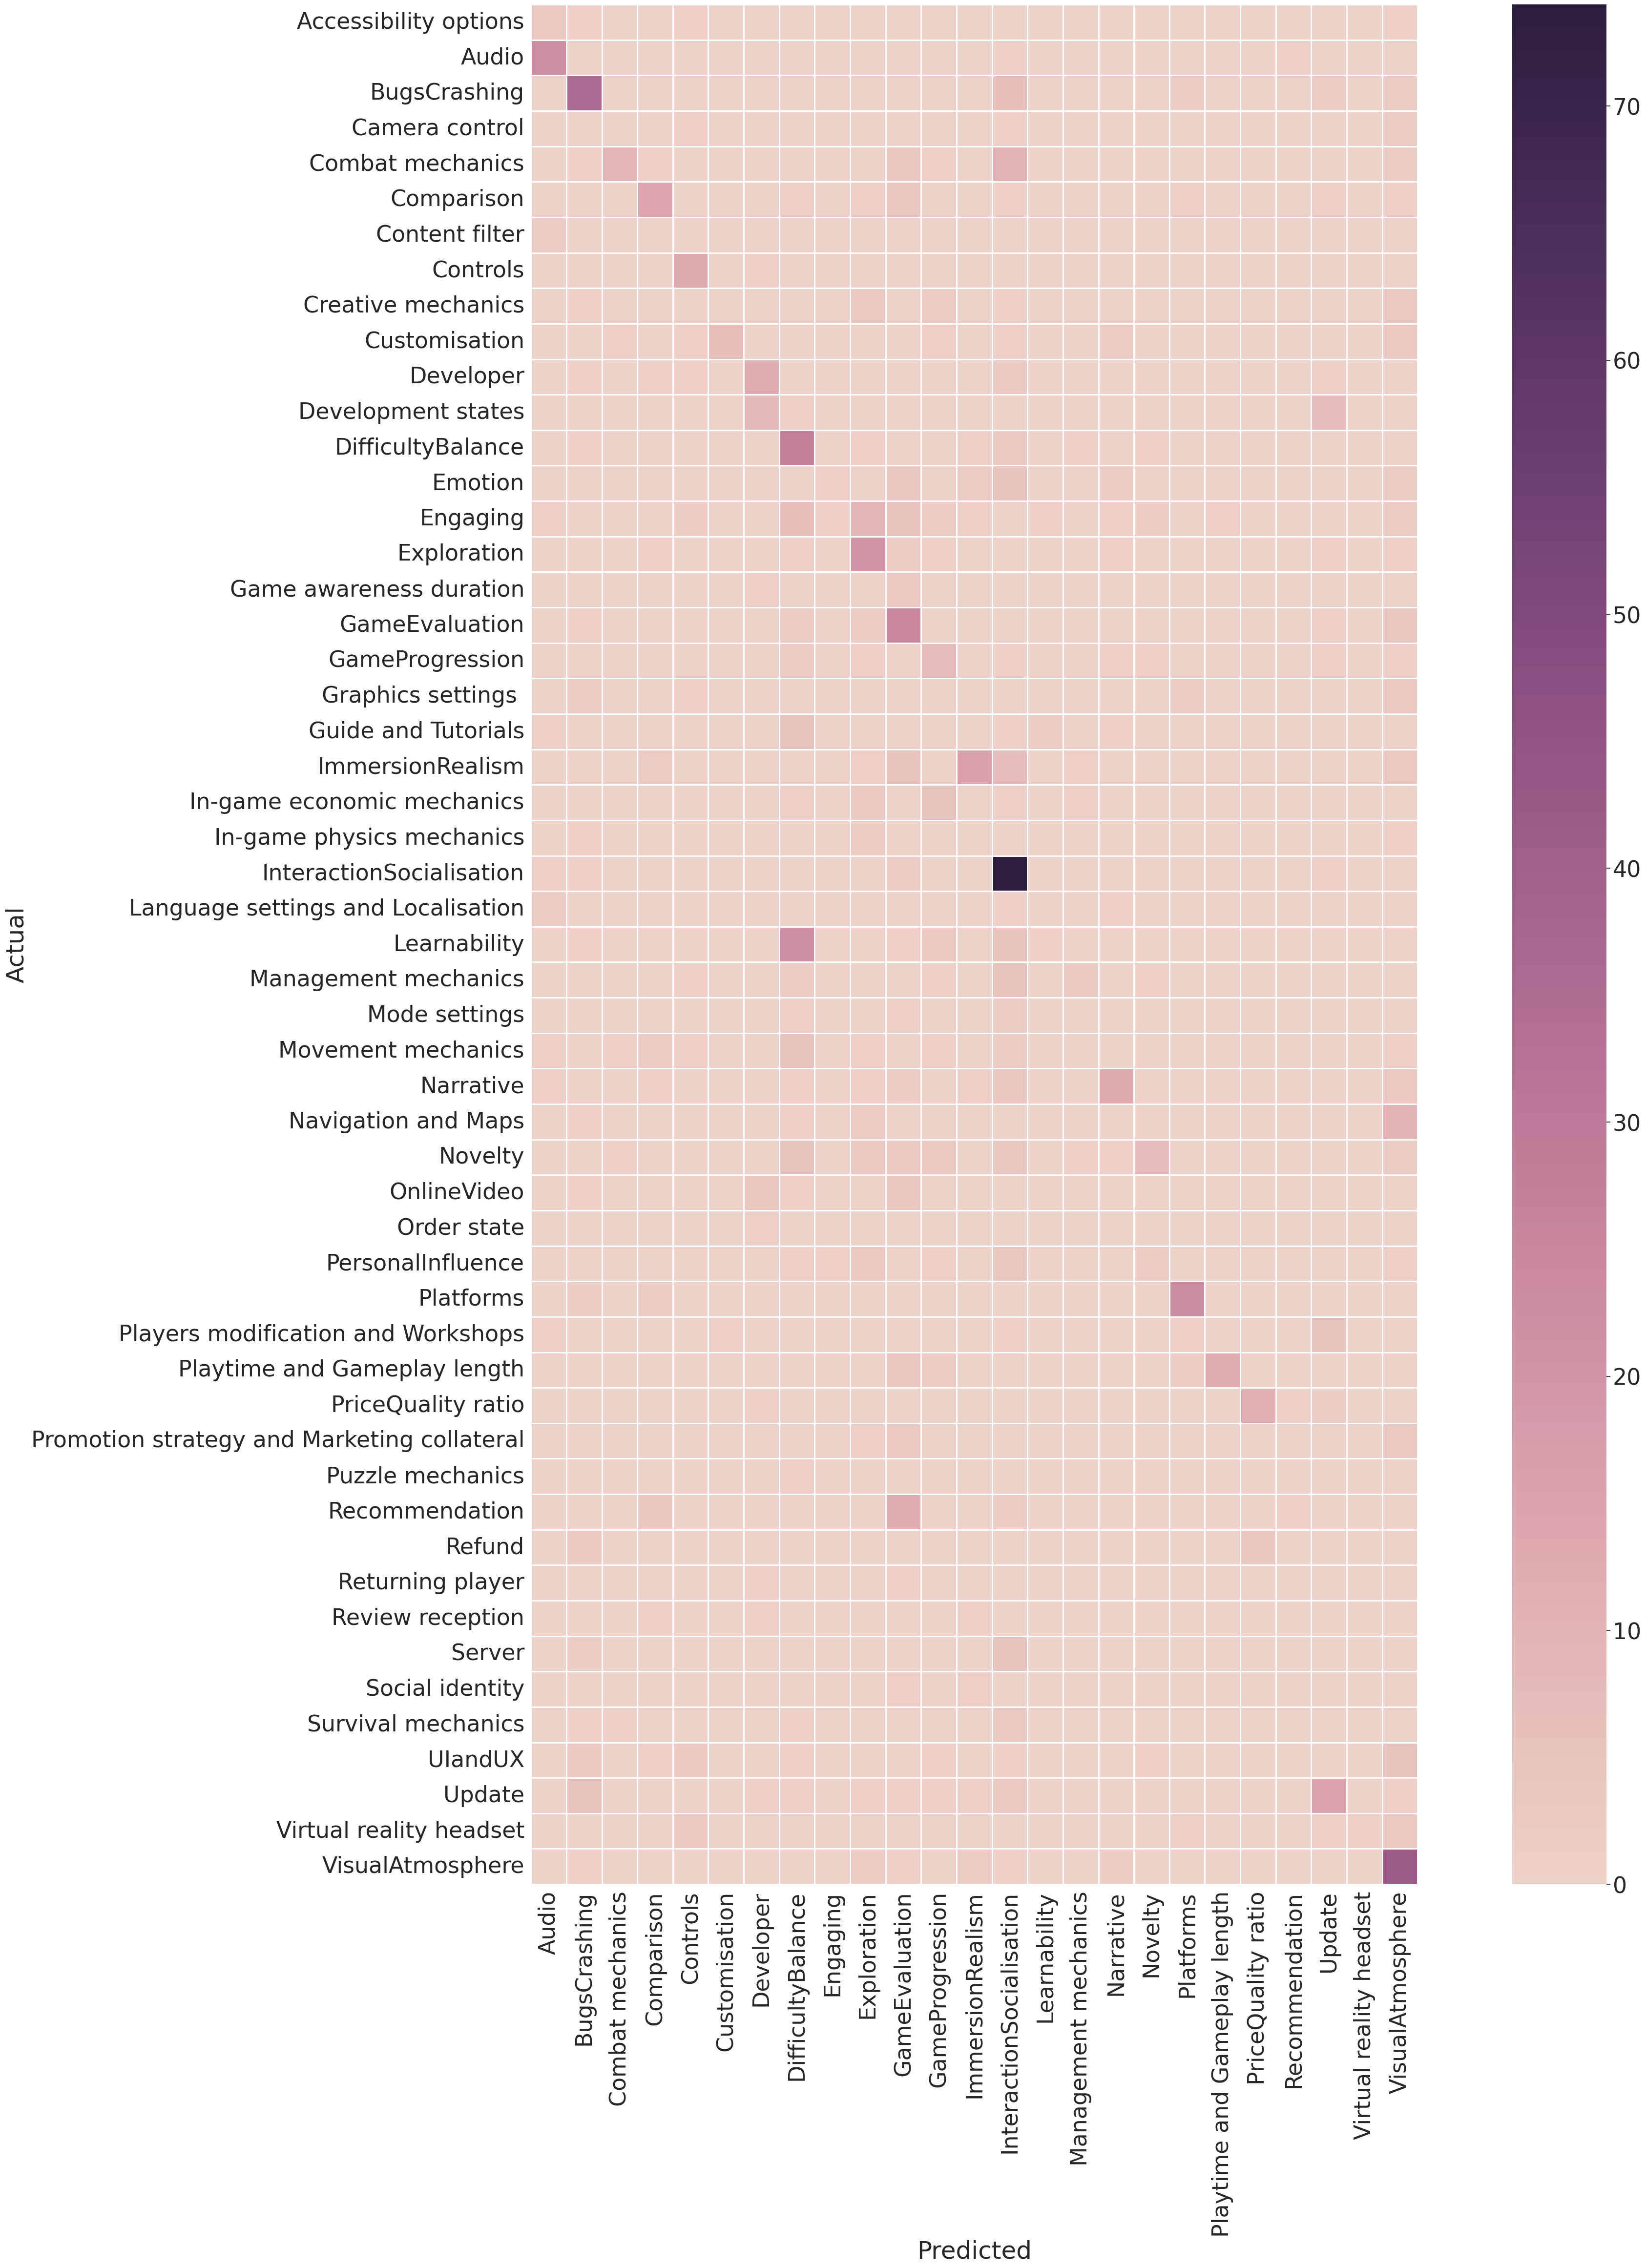

In [ ]:
plt.figure(figsize = (50,50))

sn.set(font_scale=3) # for label size
sn.heatmap(df_confusion,  annot_kws={"size": 22}, cmap=sn.cubehelix_palette(as_cmap=True), fmt=".2f", square=True, linewidths=1, linecolor = "white")

plt.show()

In [ ]:
from sklearn.preprocessing import minmax_scale
df_confusion[:] = minmax_scale(df_confusion)

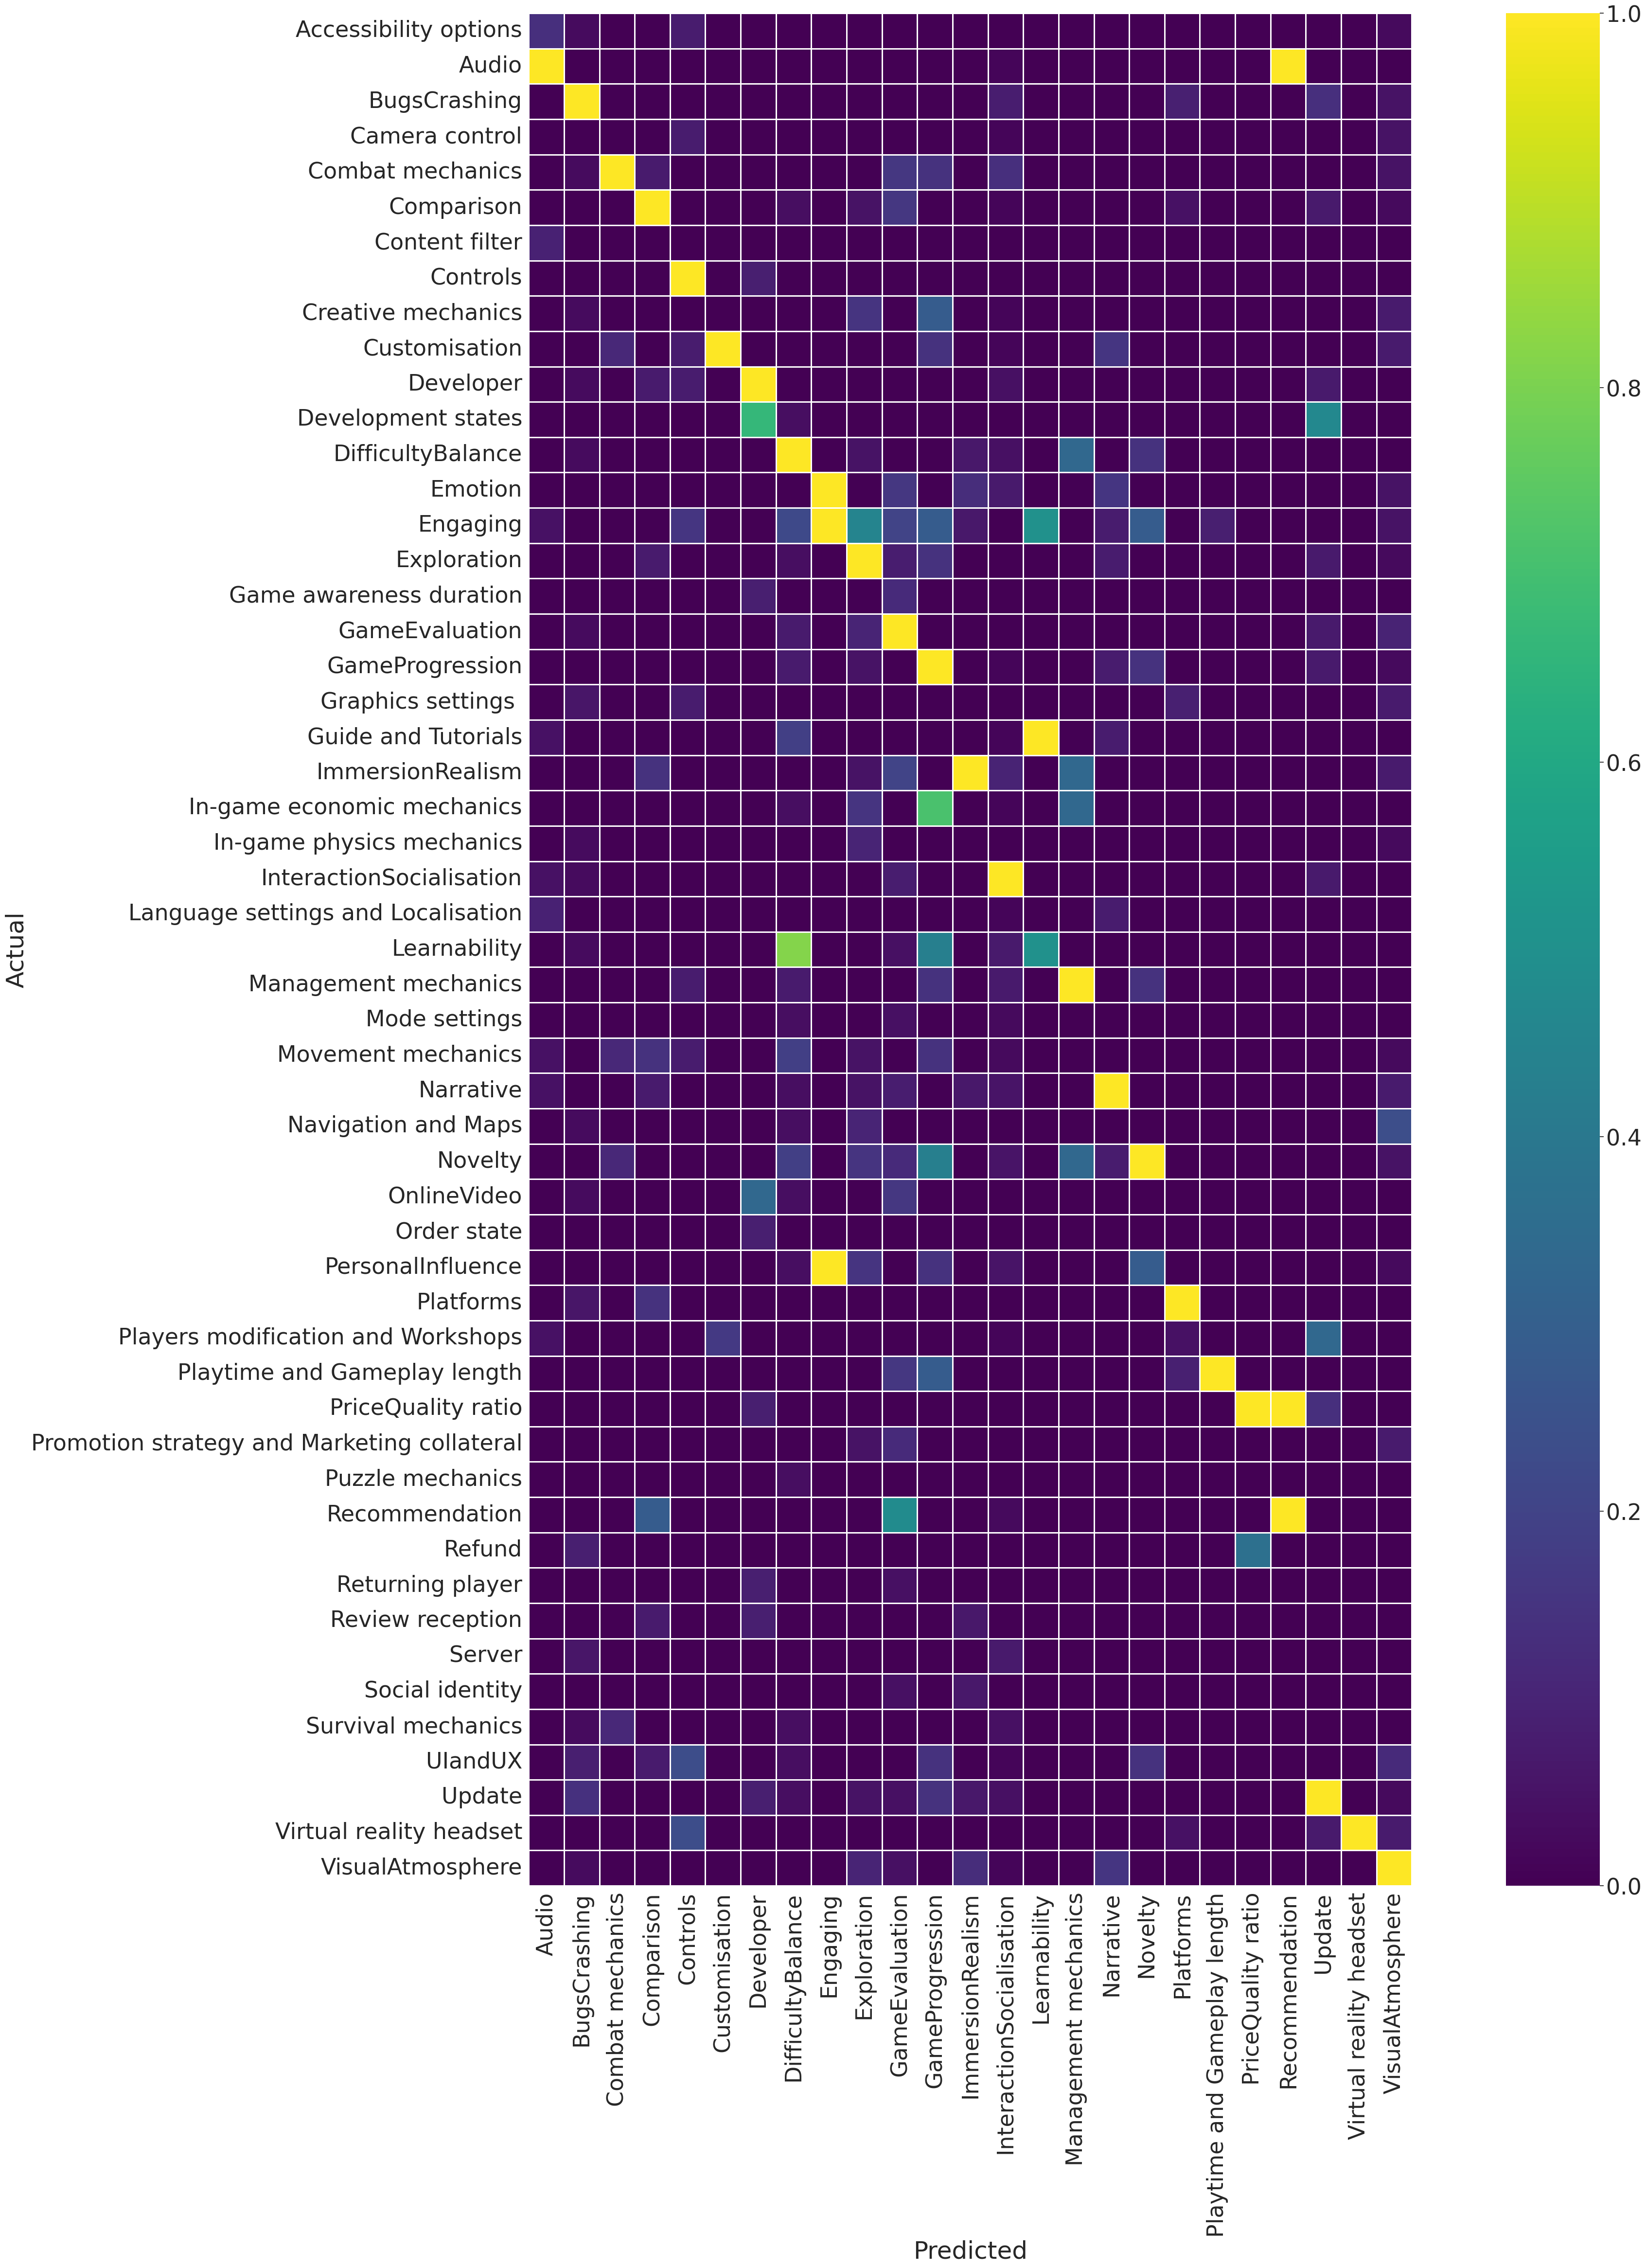

In [ ]:
plt.figure(figsize = (50,50))

sn.set(font_scale=3) # for label size
sn.heatmap(df_confusion,  annot_kws={"size": 22}, cmap="viridis", fmt=".2f", square=True, linewidths=1, linecolor = "white")

plt.show()

In [ ]:
%%shell
# jupyter nbconvert --to html /content/BERTopic.ipynb
# jupyter nbconvert --to html /content/Zero_train.ipynb
jupyter nbconvert --to html BERTopic.ipynb


[NbConvertApp] Converting notebook BERTopic.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 487, in ex

CalledProcessError: Command '# jupyter nbconvert --to html /content/BERTopic.ipynb
# jupyter nbconvert --to html /content/Zero_train.ipynb
jupyter nbconvert --to html BERTopic.ipynb
' returned non-zero exit status 1.